Keras로 MF 구현하기

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adamax
from chapter7_modules import get_dataset_2, RMSE
import multiprocessing as mp
import pandas as pd
import numpy as np

n_CPU = mp.cpu_count()

_, _, ratings = get_dataset_2()

K = 200
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)
R = Dot(axes=2)([P_embedding, Q_embedding])
R = Add()([R, user_bias])
R = Flatten()(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  metrics=[RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ratings[['user_id', 'movie_id']], ratings['rating'], train_size=0.8, random_state=10)

In [3]:
y_train.mean()

3.528825

In [4]:
fit_kwargs = {
  'x':[X_train.user_id.values, X_train.movie_id.values],
  'y':y_train.values - y_train.mean(),
  'epochs':60,
  'batch_size':256,
  'validation_data': (
    [X_test.user_id.values, X_test.movie_id.values],
    y_test.values - y_test.mean()
  ),
  'workers':n_CPU
}

result = model.fit(**fit_kwargs)

Epoch 1/60
313/313 [==============================] - 2s 3ms/step - loss: 5.2553 - RMSE: 1.1257 - val_loss: 4.9993 - val_RMSE: 1.1236
Epoch 2/60
313/313 [==============================] - 1s 3ms/step - loss: 4.7680 - RMSE: 1.1245 - val_loss: 4.5420 - val_RMSE: 1.1224
Epoch 3/60
313/313 [==============================] - 1s 3ms/step - loss: 4.3380 - RMSE: 1.1230 - val_loss: 4.1386 - val_RMSE: 1.1213
Epoch 4/60
313/313 [==============================] - 1s 3ms/step - loss: 3.9586 - RMSE: 1.1222 - val_loss: 3.7826 - val_RMSE: 1.1202
Epoch 5/60
313/313 [==============================] - 1s 3ms/step - loss: 3.6240 - RMSE: 1.1211 - val_loss: 3.4686 - val_RMSE: 1.1193
Epoch 6/60
313/313 [==============================] - 1s 3ms/step - loss: 3.3286 - RMSE: 1.1201 - val_loss: 3.1916 - val_RMSE: 1.1184
Epoch 7/60
313/313 [==============================] - 1s 3ms/step - loss: 3.0681 - RMSE: 1.1192 - val_loss: 2.9472 - val_RMSE: 1.1176
Epoch 8/60
313/313 [==============================] - 1s 3ms/s

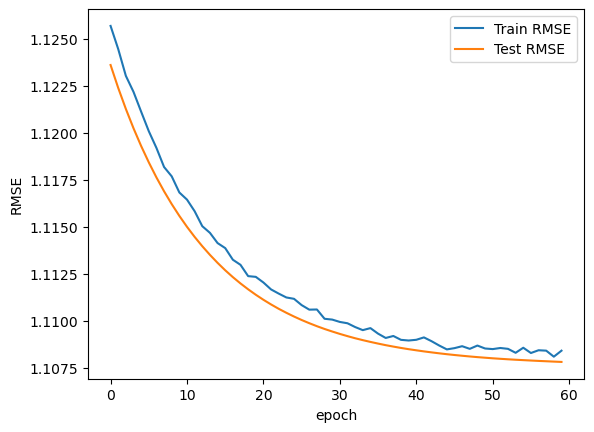

In [5]:
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [6]:
user_ids = X_test.user_id.values[:6]
movie_ids = X_test.movie_id.values[:6]

predictions = model.predict([user_ids, movie_ids]) + y_train.mean()

result_df = pd.DataFrame()
result_df['Actuals'] = y_test.values[:6]  
result_df['Predictions'] = predictions 

result_df

1/1 [==============================] - 0s 89ms/step


,Actuals,Predictions
0,4,3.488547
1,1,3.530004
2,4,3.535635
3,3,3.539645
4,1,3.537844
5,4,3.521601


In [13]:
from chapter7_modules import RMSE2

user_ids = X_test.user_id.values
movie_ids = X_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids])
y_pred = np.ravel(y_pred, order='C') + y_train.mean()# 2 dim -> 1 dim 
y_true = y_test.values 

RMSE2(y_true, y_pred)

625/625 [==============================] - 1s 1ms/step


1.1090381514744196

은닉층 추가

In [ ]:
from sklearn.model_selection import train_test_split

_, _, ratings = get_dataset_2()


X_train, X_test, y_train, y_test = train_test_split(
  ratings[['user_id', 'movie_id']], 
  ratings['rating'], train_size=0.8, 
  random_state=10
)

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adamax
from chapter7_modules import get_dataset_2, RMSE
import multiprocessing as mp
import pandas as pd
import numpy as np

n_CPU = mp.cpu_count()

_, _, ratings = get_dataset_2()

K = 200
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

user = Input(shape=(1, ))
item = Input(shape=(1, ))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers , 단순히 합치는게 어떤 의미가 있는거지?
P_embedding_flatten = Flatten()(P_embedding)
Q_embedding_flatten = Flatten()(Q_embedding)
user_bias_flatten = Flatten()(user_bias)
item_bias_flatten = Flatten()(item_bias)
R = Concatenate()([P_embedding_flatten, Q_embedding_flatten, user_bias_flatten, item_bias_flatten])

R = Dense(2048)(R)
R = Activation('relu')(R)

R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  metrics=[RMSE]
)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_53 (Embedding)       (None, 1, 200)       188800      ['input_28[0][0]']               
                                                                                                  
 embedding_54 (Embedding)       (None, 1, 200)       336600      ['input_29[0][0]']               
                                                                                           

In [33]:
fit_kwargs = {
  'x':[X_train.user_id.values, X_train.movie_id.values],
  'y':y_train.values - y_train.mean(),
  'epochs':65,
  'batch_size':512,
  'validation_data': (
    [X_test.user_id.values, X_test.movie_id.values],
    y_test.values - y_train.mean()
  ),
  'workers':n_CPU
}

result = model.fit(**fit_kwargs)

Epoch 1/65
157/157 [==============================] - 4s 23ms/step - loss: 5.3833 - RMSE: 1.1256 - val_loss: 5.2477 - val_RMSE: 1.1223
Epoch 2/65
157/157 [==============================] - 4s 22ms/step - loss: 5.1232 - RMSE: 1.1243 - val_loss: 4.9957 - val_RMSE: 1.1213
Epoch 3/65
157/157 [==============================] - 4s 26ms/step - loss: 4.8789 - RMSE: 1.1231 - val_loss: 4.7594 - val_RMSE: 1.1208
Epoch 4/65
157/157 [==============================] - 4s 24ms/step - loss: 4.6495 - RMSE: 1.1227 - val_loss: 4.5370 - val_RMSE: 1.1197
Epoch 5/65
157/157 [==============================] - 4s 26ms/step - loss: 4.4340 - RMSE: 1.1214 - val_loss: 4.3283 - val_RMSE: 1.1189
Epoch 6/65
157/157 [==============================] - 4s 24ms/step - loss: 4.2316 - RMSE: 1.1208 - val_loss: 4.1323 - val_RMSE: 1.1181
Epoch 7/65
157/157 [==============================] - 4s 24ms/step - loss: 4.0415 - RMSE: 1.1195 - val_loss: 3.9482 - val_RMSE: 1.1173
Epoch 8/65
157/157 [==============================] - 4

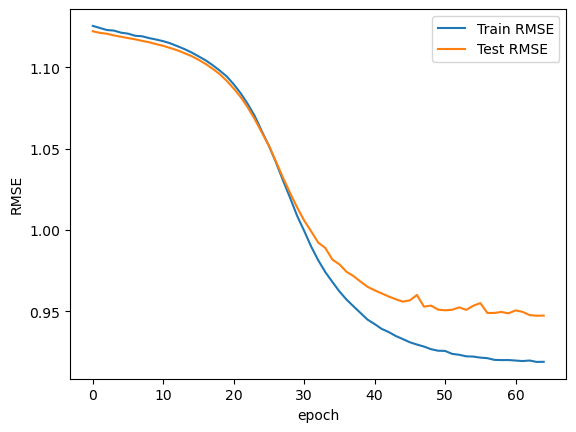

In [34]:
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

변수에 직업 추가  
여기에는 직업에 따라 영화 선호도가 달라질 것이라는 가정이 담겨있음

In [43]:
from sklearn.model_selection import train_test_split
from chapter7_modules import get_dataset_2

users, _, ratings = get_dataset_2()

occupation = {}
def convert_occ(x):
  if x in occupation:
    return occupation[x]
  else:
    occupation[x] = len(occupation)
    return occupation[x]
users['occupation'] = users['occupation'].apply(convert_occ)

ratings = pd.merge(ratings, users, on='user_id')

X_train, X_test, y_train, y_test = train_test_split(
  ratings[['user_id', 'movie_id', 'occupation']], 
  ratings['rating'], train_size=0.8, 
  random_state=10
)

In [46]:

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adamax
from chapter7_modules import get_dataset_2, RMSE
import multiprocessing as mp
import pandas as pd
import numpy as np

n_CPU = mp.cpu_count()



L = len(occupation)
  
K = 200
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

user = Input(shape=(1, ))
item = Input(shape=(1, ))
occ = Input(shape=(1, ))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers , 단순히 합치는게 어떤 의미가 있는거지?
P_embedding_flatten = Flatten()(P_embedding)
Q_embedding_flatten = Flatten()(Q_embedding)
user_bias_flatten = Flatten()(user_bias)
item_bias_flatten = Flatten()(item_bias)
occ_embedding_flatten = Flatten()(occ_embedding)
R = Concatenate()([P_embedding_flatten, Q_embedding_flatten, user_bias_flatten, item_bias_flatten, occ_embedding_flatten])

R = Dense(2048)(R)
R = Activation('relu')(R)

R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item, occ], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  metrics=[RMSE]
)
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_62 (Embedding)       (None, 1, 200)       188800      ['input_33[0][0]']               
                                                                                           

In [47]:
fit_kwargs = {
  'x':[X_train.user_id.values, X_train.movie_id.values, X_train.occupation.values],
  'y':y_train.values - y_train.mean(),
  'epochs':65,
  'batch_size':512,
  'validation_data': (
    [X_test.user_id.values, X_test.movie_id.values, X_test.occupation.values],
    y_test.values - y_train.mean()
  ),
  'workers':n_CPU
}

result = model.fit(**fit_kwargs)

Epoch 1/65
157/157 [==============================] - 4s 22ms/step - loss: 5.3972 - RMSE: 1.1249 - val_loss: 5.2647 - val_RMSE: 1.1290
Epoch 2/65
157/157 [==============================] - 3s 22ms/step - loss: 5.1360 - RMSE: 1.1238 - val_loss: 5.0118 - val_RMSE: 1.1280
Epoch 3/65
157/157 [==============================] - 3s 21ms/step - loss: 4.8908 - RMSE: 1.1224 - val_loss: 4.7744 - val_RMSE: 1.1271
Epoch 4/65
157/157 [==============================] - 3s 22ms/step - loss: 4.6605 - RMSE: 1.1216 - val_loss: 4.5513 - val_RMSE: 1.1262
Epoch 5/65
157/157 [==============================] - 4s 23ms/step - loss: 4.4441 - RMSE: 1.1208 - val_loss: 4.3418 - val_RMSE: 1.1253
Epoch 6/65
157/157 [==============================] - 4s 23ms/step - loss: 4.2409 - RMSE: 1.1196 - val_loss: 4.1453 - val_RMSE: 1.1245
Epoch 7/65
157/157 [==============================] - 4s 23ms/step - loss: 4.0500 - RMSE: 1.1183 - val_loss: 3.9602 - val_RMSE: 1.1234
Epoch 8/65
157/157 [==============================] - 3

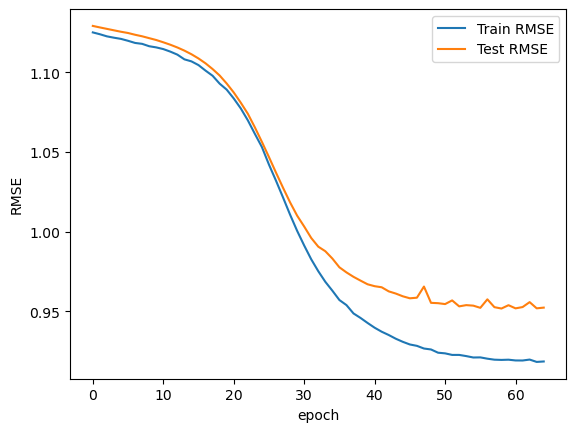

In [48]:
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

연습문제   
사용자의 나이까지를 입력으로 추가한 신경망.   
사용자 나이 데이터는 곧바로 dense layer를 통과 후 다른 layer들과 concatenate 시켜라